<a href="https://colab.research.google.com/github/aparnashenoy/ml/blob/master/feature_importance_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import graphviz 
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
path = '/gdrive/My Drive/'

In [6]:
dataset = pd.read_csv(path +'Copy of train.psv', sep='|')

In [7]:
dataset.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

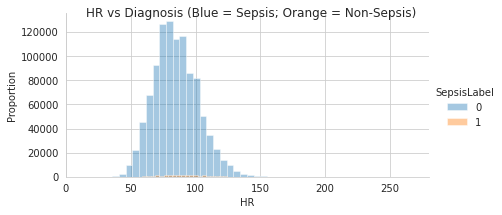

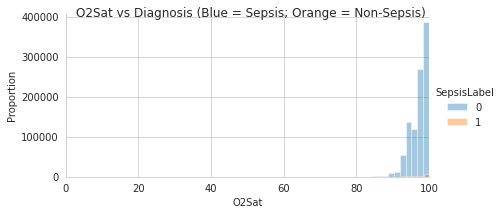

In [8]:
def plotHistogram(values,label,feature,title):
    sns.set_style("whitegrid")
    plotOne = sns.FacetGrid(values, hue=label,aspect=2)
    plotOne.map(sns.distplot,feature,kde=False)
    plotOne.set(xlim=(0, values[feature].max()))
    plotOne.add_legend()
    plotOne.set_axis_labels(feature, 'Proportion')
    plotOne.fig.suptitle(title)
    plt.show()
plotHistogram(dataset,"SepsisLabel",'HR','HR vs Diagnosis (Blue = Sepsis; Orange = Non-Sepsis)')
plotHistogram(dataset,"SepsisLabel",'O2Sat','O2Sat vs Diagnosis (Blue = Sepsis; Orange = Non-Sepsis)')


In [9]:
dataset2 = dataset.iloc[:, :-1]
print("# of Rows, # of Columns: ",dataset2.shape)
print("\nColumn Name           # of Null Values\n")
print((dataset2[:].isnull().sum()))

# of Rows, # of Columns:  (1167202, 40)

Column Name           # of Null Values

HR                   107735
O2Sat                149329
Temp                 772577
SBP                  173917
MAP                  137670
DBP                  434103
Resp                 157166
EtCO2               1139801
BaseExcess          1083871
HCO3                1102792
FiO2                1046735
pH                  1068276
PaCO2               1089567
SaO2                1120935
AST                 1148690
BUN                 1082105
Alkalinephos        1148956
Calcium             1102473
Chloride            1099107
Creatinine          1094076
Bilirubin_direct    1165131
Glucose              987695
Lactate             1132987
Magnesium           1087792
Phosphate           1116417
Potassium           1052545
Bilirubin_total     1150776
TroponinI           1159014
Hct                 1052275
Hgb                 1075317
PTT                 1125284
WBC                 1088216
Fibrinogen          115

In [10]:
print("# of Rows, # of Columns: ",dataset2.shape)
print("\nColumn Name              % Null Values\n")
print((dataset2[:].isnull().sum())/1167202*100)

# of Rows, # of Columns:  (1167202, 40)

Column Name              % Null Values

HR                   9.230193
O2Sat               12.793758
Temp                66.190514
SBP                 14.900334
MAP                 11.794874
DBP                 37.191763
Resp                13.465193
EtCO2               97.652420
BaseExcess          92.860619
HCO3                94.481675
FiO2                89.678993
pH                  91.524518
PaCO2               93.348623
SaO2                96.036076
AST                 98.413985
BUN                 92.709317
Alkalinephos        98.436774
Calcium             94.454345
Chloride            94.165963
Creatinine          93.734932
Bilirubin_direct    99.822567
Glucose             84.620743
Lactate             97.068631
Magnesium           93.196550
Phosphate           95.648996
Potassium           90.176765
Bilirubin_total     98.592703
TroponinI           99.298493
Hct                 90.153632
Hgb                 92.127755
PTT                

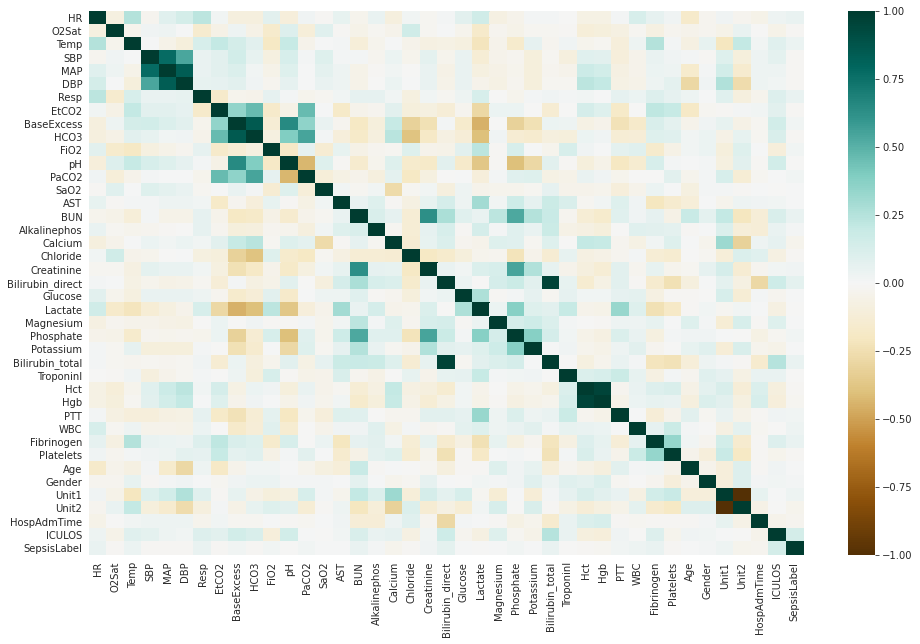

In [11]:
plt.figure(figsize=(16, 10))
g = sns.heatmap(dataset.corr(),cmap="BrBG",annot=False)

In [12]:
dataset.corr()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
HR,1.000000,-0.080252,0.256414,-0.027638,0.087324,0.147383,0.231644,0.021445,-0.092131,-0.092696,0.081493,-0.102134,0.025006,-0.010947,0.061988,-0.036661,0.049247,-0.092506,0.015914,-0.019030,0.012541,0.079646,0.162206,-0.070696,-0.043068,0.011915,0.010620,-0.002126,-0.068583,-0.067607,0.013293,0.131958,0.069636,0.026210,-0.166032,-0.029581,0.026812,-0.026812,-0.052653,0.036702,0.047217
O2Sat,-0.080252,1.000000,-0.031879,0.029079,0.031521,0.004453,-0.154377,-0.060180,0.032496,-0.060769,-0.159725,0.108289,-0.116377,0.092191,-0.014827,-0.048186,-0.020911,-0.040540,0.159288,-0.020703,0.000606,-0.033220,-0.164988,-0.025191,-0.052187,-0.019823,-0.022108,-0.014618,-0.111495,-0.095170,-0.075033,-0.023434,-0.076081,-0.023541,-0.046722,-0.030784,-0.049686,0.049686,-0.004564,-0.051458,-0.007890
Temp,0.256414,-0.031879,1.000000,0.004381,-0.051019,-0.094833,0.128111,0.206220,0.147893,0.078476,-0.191411,0.198461,-0.044888,0.005888,0.010397,-0.116741,-0.036982,0.005939,-0.043948,-0.072624,-0.066979,-0.082455,-0.216687,-0.042872,-0.159036,0.070147,-0.028380,0.024792,-0.034578,-0.022776,-0.108210,0.031987,0.252934,0.007903,-0.075983,0.055821,-0.207411,0.207411,0.016649,0.093721,0.045316
SBP,-0.027638,0.029079,0.004381,1.000000,0.779194,0.545016,0.051596,0.083562,0.151157,0.057507,-0.080035,0.126376,0.012224,0.097576,0.014035,0.009826,-0.026850,0.043351,-0.038009,0.078061,-0.034594,0.052086,-0.130803,-0.042031,-0.029609,-0.095031,-0.020893,-0.089905,0.091195,0.079730,-0.106686,-0.040739,0.050286,0.028592,0.015006,-0.009295,0.097777,-0.097777,0.035414,0.074029,-0.010465
MAP,0.087324,0.031521,-0.051019,0.779194,1.000000,0.843535,0.049206,0.081581,0.111383,0.022110,-0.052465,0.093870,0.001502,0.071876,0.031299,-0.050911,-0.014157,0.020040,-0.002328,0.054264,-0.057088,0.051572,-0.079417,-0.057343,-0.035131,-0.093897,-0.030895,-0.042299,0.174158,0.156197,-0.071730,-0.040434,0.044535,0.036950,-0.159370,0.012714,0.155526,-0.155526,0.035015,0.038142,-0.015005
DBP,0.147383,0.004453,-0.094833,0.545016,0.843535,1.000000,0.061619,0.064410,0.080261,0.023653,-0.029021,0.062831,0.000742,0.047813,0.032176,-0.053061,-0.001713,0.042500,0.003093,0.050301,-0.053376,0.052861,-0.040805,-0.064130,-0.030404,-0.095430,-0.017174,-0.015972,0.230245,0.210337,-0.065887,-0.048698,0.038423,0.077006,-0.285714,0.024422,0.258358,-0.258358,0.036911,0.019351,-0.013029
Resp,0.231644,-0.154377,0.128111,0.051596,0.049206,0.061619,1.000000,-0.170192,-0.034260,-0.041546,0.068709,0.014862,-0.036584,-0.020223,0.022658,0.068602,0.068913,0.017485,-0.079110,0.021006,-0.020728,0.036884,0.125766,-0.003714,-0.037298,0.009051,0.024745,0.009315,0.019084,0.004786,0.064183,0.043822,0.106778,0.066775,0.036366,0.006252,0.089932,-0.089932,-0.033204,0.109140,0.047146
EtCO2,0.021445,-0.060180,0.206220,0.083562,0.081581,0.064410,-0.170192,1.000000,0.348754,0.467890,-0.171545,-0.056506,0.465049,0.006557,-0.178056,-0.042154,-0.026117,0.081636,-0.095218,-0.082748,-0.118392,-0.026177,-0.285640,0.042481,0.042625,-0.006593,-0.133962,-0.004238,0.137031,0.100697,-0.179083,-0.002557,0.225415,0.199669,-0.181113,-0.015860,-0.010012,0.010012,0.022020,0.082665,-0.013452
BaseExcess,-0.092131,0.032496,0.147893,0.151157,0.111383,0.080261,-0.034260,0.348754,1.000000,0.856239,-0.131027,0.649252,0.356030,0.049198,-0.028895,-0.192995,-0.096254,0.197026,-0.317370,-0.235360,0.015444,-0.160101,-0.447932,-0.004000,-0.319350,-0.236240,0.042872,0.033429,-0.063094,-0.039941,-0.233874,-0.166152,0.119997,0.076622,-0.043856,0.024846,0.058376,-0.058376,-0.022215,0.155257,0.017102
HCO3,-0.092696,-0.060769,0.078476,0.057507,0.022110,0.023653,-0.041546,0.467890,0.856239,1.000000,-0.082483,0.394855,0.551994,0.008932,-0.101855,-0.172267,-0.

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE( random_state= 0 )

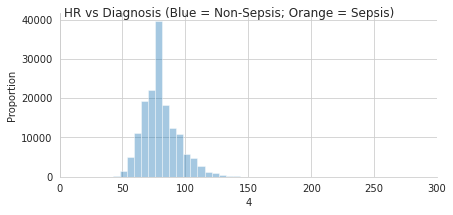

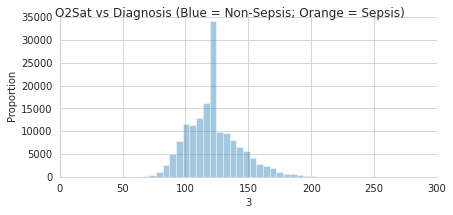

In [14]:
data = pd.read_csv(path +'Copy of train.psv', sep='|')
data=data.sample(n=100000,random_state=1,replace=True)
categorical = data.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
X_train2 = imputer.fit_transform(X_train)
X_test2 = imputer.transform(X_test)
X_train2, y_train = smote.fit_resample(X_train2, y_train)
X_test2, y_test = smote.fit_resample(X_test2, y_test)
X_train3 = pd.DataFrame(X_train2)
plotHistogram(X_train3,None,4,'HR vs Diagnosis (Blue = Non-Sepsis; Orange = Sepsis)')
plotHistogram(X_train3,None,3,'O2Sat vs Diagnosis (Blue = Non-Sepsis; Orange = Sepsis)')

In [15]:
labels = {0:'HR', 1:'O2Sat', 2:'Temp', 3:'SBP', 4:'MAP', 5:'DBP', 6:'Resp', 7:'EtCO2',
       8:'BaseExcess', 9:'HCO3', 10:'FiO2', 11:'pH', 12:'PaCO2', 13:'SaO2', 14:'AST', 15:'BUN',
       16:'Alkalinephos', 17:'Calcium', 18:'Chloride', 19:'Creatinine', 20:'Bilirubin_direct',
       21:'Glucose', 22:'Lactate', 23:'Magnesium', 24:'Phosphate', 25:'Potassium',
       26:'Bilirubin_total', 27:'TroponinI', 28:'Hct', 29:'Hgb', 30:'PTT', 31:'WBC',
       32:'Fibrinogen', 33:'Platelets', 34:'Age', 35:'Gender', 36:'Unit1', 37:'Unit2',
       38:'HospAdmTime', 39:'ICULOS'}
print(labels)
print("\nColumn #, # of Zero Values\n")
print((X_train3[:] == np.nan).sum())
# data[:] = data[:].replace(0, np.NaN)
# print("\nColumn #, # of Null Values\n")
# print(np.isnan(X_train3).sum())

{0: 'HR', 1: 'O2Sat', 2: 'Temp', 3: 'SBP', 4: 'MAP', 5: 'DBP', 6: 'Resp', 7: 'EtCO2', 8: 'BaseExcess', 9: 'HCO3', 10: 'FiO2', 11: 'pH', 12: 'PaCO2', 13: 'SaO2', 14: 'AST', 15: 'BUN', 16: 'Alkalinephos', 17: 'Calcium', 18: 'Chloride', 19: 'Creatinine', 20: 'Bilirubin_direct', 21: 'Glucose', 22: 'Lactate', 23: 'Magnesium', 24: 'Phosphate', 25: 'Potassium', 26: 'Bilirubin_total', 27: 'TroponinI', 28: 'Hct', 29: 'Hgb', 30: 'PTT', 31: 'WBC', 32: 'Fibrinogen', 33: 'Platelets', 34: 'Age', 35: 'Gender', 36: 'Unit1', 37: 'Unit2', 38: 'HospAdmTime', 39: 'ICULOS'}

Column #, # of Zero Values

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
dtype: int64


In [17]:
from xgboost import plot_importance

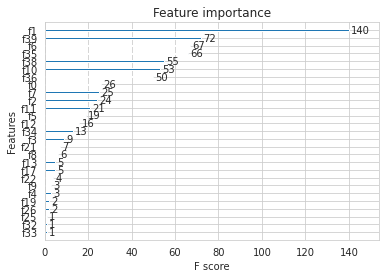

In [23]:
model = XGBClassifier()
model.fit(X_train2, y_train)
# plot feature importance
plot_importance(model)
plt.show()


[0.02264768 0.07603006 0.03468039 0.01291078 0.01186336 0.02817703
 0.0493906  0.01620525 0.00335745 0.00972759 0.03539194 0.03800895
 0.02045171 0.01194709 0.         0.         0.         0.00251329
 0.         0.00951737 0.         0.01057764 0.01081907 0.
 0.         0.00962923 0.00405548 0.         0.         0.
 0.         0.         0.00199346 0.00123762 0.00850307 0.18566658
 0.2455196  0.         0.02573779 0.1134399 ]


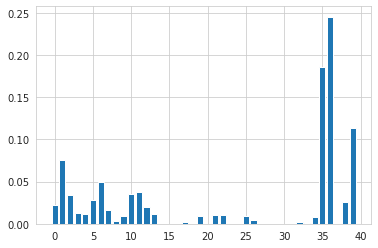

In [24]:
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [29]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

In [30]:
y_pred = model.predict(X_test2)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train2)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test2)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.000, n=40, Accuracy: 93.92%
Thresh=0.001, n=27, Accuracy: 93.92%
Thresh=0.002, n=26, Accuracy: 93.92%
Thresh=0.003, n=25, Accuracy: 93.92%
Thresh=0.003, n=24, Accuracy: 93.94%
Thresh=0.004, n=23, Accuracy: 93.63%
Thresh=0.009, n=22, Accuracy: 93.63%
Thresh=0.010, n=21, Accuracy: 93.90%
Thresh=0.010, n=20, Accuracy: 93.79%
Thresh=0.010, n=19, Accuracy: 93.62%
Thresh=0.011, n=18, Accuracy: 93.75%
Thresh=0.011, n=17, Accuracy: 93.69%
Thresh=0.012, n=16, Accuracy: 94.09%
Thresh=0.012, n=15, Accuracy: 93.99%
Thresh=0.013, n=14, A